# Cartpole DQN

Inspired from [here](https://gist.github.com/muety/2a6722407117e4d668921fce53845432#file-dqn_cartpole-py).

In [12]:
import tensorflow as tf
import gym
import numpy as np
import itertools
from random import sample
from collections import deque
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [7]:
class DQN:
    
    def __init__(self, env, n_episodes, epsilon_decay, lr, gamma):
        self.env = gym.make(env)
        self.gamma = gamma
        self.epsilon = 1.0
        self.min_epsilon = 0.01
        self.epsilon_decay = epsilon_decay
        self.lr = lr
        self.n_episodes = n_episodes
        
        self.nA = self.env.action_space.n
        self.nO = len(self.env.observation_space.sample())
        
        self.memory = deque(maxlen=100000)
        
        
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(16, input_dim=4, activation='relu'))
        self.model.add(tf.keras.layers.Dense(32, activation='relu'))
        self.model.add(tf.keras.layers.Dense(16, activation='relu'))
        self.model.add(tf.keras.layers.Dense(self.nA, activation='linear'))
        self.model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.lr))
        
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def replay(self, batch_size=32):
        X, Y = [], []
        
        if len(self.memory) < 10000:
            return
                
        batch = sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in batch:
            y_target = self.model.predict(state)[0]
            y_target[action] = reward if done else reward + self.gamma*max(self.model.predict(next_state)[0])
            
            X.append(state[0])
            Y.append(y_target)
            
        self.model.fit(np.array(X), np.array(Y))
        
        
    def run(self):
        
        scores = deque(maxlen=100)
        
        mean_scores_history = []
        for episode in itertools.count():
            state = np.reshape(self.env.reset(), (1,4))
            done = False
            t = 0
            while not done:
                
                if np.random.random() <= self.epsilon:
                    action = self.env.action_space.sample()
                else:
                    action = np.argmax(self.model.predict(state))
                
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, (1,4))
                
                self.remember(state, action, reward, next_state, done)
                state = next_state
                t+=1
                
                
            scores.append(t)
            mean_score = np.mean(scores)
            mean_scores_history.append(mean_score)
            
            if mean_score >= 195 and episode >= 100:
                print('Ran {} episodes. Solved after {} episodes ✔'.format(episode, episode - 100))
                return np.array(mean_scores_history)
            
            self.replay(64)
            
            if self.epsilon > self.min_epsilon:
                self.epsilon *= self.epsilon_decay

            clear_output(wait=True)
            print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(episode, mean_score))
    

In [8]:
dqn = DQN("CartPole-v1", 1000, 0.99, 0.001, 0.95)

DQN has a high variance so with every new run, it might solves the cartpole problem faster or slower.

In [9]:
scores_history = dqn.run()

[Episode 1502] - Mean survival time over last 100 episodes was 194.89 ticks.
Ran 1503 episodes. Solved after 1403 episodes ✔


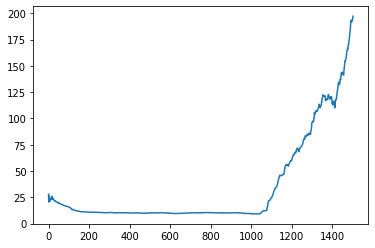

In [13]:
plt.plot(scores_history)